In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 55)

## Data loading

In [3]:
def load_data():
    df = pd.read_csv("TM(O)N_dataset.csv")
    convert_dict = {
                    "pH": float,
                    'Catalyst Loading (mg/cm2)': float,
                    "Presence of atoms (other than TMs)" : float,
                    "Average d electrons": float,
                    'Overpotential (mV)': float
                }

    df = df.astype(convert_dict)
    df = df.drop(["Compound"], axis=1)
    return df

## Pre *processing*

In [4]:
atomicMassMap = {
    'cobalt': 64,
    'nickel': 59,
    'iron': 56,
    "molybdenum": 96,
    'manganese': 55,
    "copper": 64,
    "zinc": 65,
    "chromium": 52,
    "vanadium": 51,
    "tungsten": 184,
    "titanium": 48,
    "iridium": 192
}

In [5]:
def mulitply_number_of_atoms_to_its_mass_number():
    for col in df.columns:
        if col.lower().split(' ')[0] in atomicMassMap:
            df[col] = df[col].values.astype(float) * atomicMassMap[col.lower().split(' ')[0]]

In [6]:
def find_and_handle_missing_values(model_name):
    print("Missing values columns:", list(df.columns[df.isnull().any()]))

    if model_name != "catboost":
        df['Catalyst Loading (mg/cm2)'].fillna(df['Catalyst Loading (mg/cm2)'].mean() , inplace = True)
        df["Average d electrons"].fillna(df['Average d electrons'].mean() , inplace = True)

## Data analysis

In [7]:
def get_number_of_features():

    training_features = df.columns[0:-1]
    continuous_features = []
    categorical_features = []

    for col in training_features:
        if df[col].dtypes == float:
            continuous_features.append(col)
        else:
            categorical_features.append(col)

    total_number_of_features = len(training_features)
    print("Total number of training features: ", total_number_of_features) 

    print("Number of continuous variables:", len(continuous_features))
    print("Continuous features:", continuous_features)

    print("Number of categorical variables: ", len(categorical_features))
    print("Categorical features:", categorical_features)

    return training_features, continuous_features, categorical_features

In [8]:
def categorical_features_count_plot(categorical_features):
    unique, counts = np.unique(df['overpotential_grades'].values, return_counts=True)
    sns.countplot(x="overpotential_grades", data=df)

In [9]:
def plot_correlation(data):
    plt.subplots(figsize=(16,16))
    dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
    plt.show()

## Train test split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
def split_data_into_train_test():
    x = df.values[:, 0:-1]
    y = df.values[:, -1]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state = 0, stratify=y
    )
    return x_train, x_test, y_train, y_test

In [12]:
def train_and_test_split():
    x_train, x_test, y_train, y_test = split_data_into_train_test()

    print(x_train[0])
    print(y_train[0])
    print(type(x_train), type(y_train))
    print("number of train data: ", len(y_train))
    print("number of test data: ", len(y_test))

    return x_train, y_train, x_test, y_test

## Error **analysis**

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def get_metrics(model, x_test, y_test):

    y_pred = model.predict(x_test)
    y_prob_pred = model.predict_proba(x_test)
    cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
    accuracy = accuracy_score(y_test, y_pred )
    class_report = classification_report(y_test, y_pred)
    
    return accuracy, cf_matrix, class_report

In [14]:
def get_feature_importance_from_trained_model(model):

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    return feature_importance, sorted_idx

In [15]:
def plot_feature_importance(feature_importance, sorted_idx):
    fig = plt.figure(figsize=(20, 10))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), training_features[sorted_idx])
    plt.title('Feature Importance')

## Encoding cat_features

In [16]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df):
    types_of_compounds = list(df['Compound Class'].value_counts().keys())
    types_of_substrates = list(df['Substrates'].value_counts().keys())
    
    labelencoder = LabelEncoder()
    df['Compound Class']= labelencoder.fit_transform(df['Compound Class'])
    df['Substrates']= labelencoder.fit_transform(df['Substrates'])

    compound_encoding_labels = {}
    a1 = list(df['Compound Class'].value_counts().keys())
    for i in range(len(a1)):
        compound_encoding_labels[types_of_compounds[i]] = a1[i]

    substrate_encoding_labels = {}
    a2 = list(df['Substrates'].value_counts().keys())
    for i in range(len(a2)):
        substrate_encoding_labels[types_of_substrates[i]] = a2[i]

    return compound_encoding_labels, substrate_encoding_labels

In [17]:
def get_overpotential_grades(overpotential):

    overpotential_grades = []
    grades = ["A", "F"]

    for potential in overpotential:
        if potential < 351:
            overpotential_grades.append('A')

        else:
            overpotential_grades.append('F')

    return overpotential_grades, grades

## Random forest

Shape of data: (305, 26)
(array(['A', 'F'], dtype=object), array([181, 124], dtype=int64))
{'Co': 0, 'Ni': 2, 'Fe': 1, 'Other TMs': 3} {'GC': 0, 'NF': 1, 'carbon_based': 3, 'TM_based': 2}
Total number of training features:  25
Number of continuous variables: 15
Continuous features: ['Presence of atoms (other than TMs)', 'Cobalt atoms', 'Nickel atoms', 'Iron atoms', 'Molybdenum atoms', 'Manganese atoms', 'Copper atoms', 'Zinc atoms', 'Chromium Atoms', 'Vanadium Atoms', 'Tungsten atoms', 'Titanium atoms', 'Average d electrons', 'pH', 'Catalyst Loading (mg/cm2)']
Number of categorical variables:  10
Categorical features: ['Compound Class', 'Composite (Y or N)', 'Presence of Carbon', 'Carbon Structures', 'N-doped Carbon Structure (0 or 1)', 'Doping (other than TMs)', 'Morphology Category', 'Grown on', 'Porous - 1, Non-Porous - 0', 'Substrates']
Missing values columns: ['Average d electrons', 'Catalyst Loading (mg/cm2)']


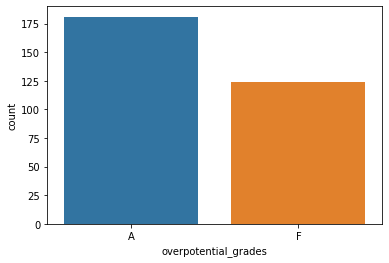

In [18]:
df = load_data()

print("Shape of data:", df.shape)

mulitply_number_of_atoms_to_its_mass_number()

overpotential_grades, grades = get_overpotential_grades(df["Overpotential (mV)"])

df['overpotential_grades'] = overpotential_grades
df = df.drop(["Overpotential (mV)"], axis=1)
print(np.unique(df['overpotential_grades'].values, return_counts=True))

compound_encoding_labels, substrate_encoding_labels = encode_categorical_features(df)
print(compound_encoding_labels, substrate_encoding_labels)

training_features, continuous_features, categorical_features = get_number_of_features()

model_name = "random_forest"
find_and_handle_missing_values(model_name)

categorical_features_count_plot(categorical_features)

In [19]:
x_train, y_train, x_test, y_test = train_and_test_split()

[0 0 0 0 0 0 3 0 0 0 0.0 192.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 2.4285714290000002 14.0 0.14]
F
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
number of train data:  244
number of test data:  61


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 0, n_estimators=100, class_weight="balanced", max_features = "log2")
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       random_state=0)

accuracy_score:  0.7868852459016393
classification_report: 
               precision    recall  f1-score   support

           A       0.81      0.83      0.82        36
           F       0.75      0.72      0.73        25

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



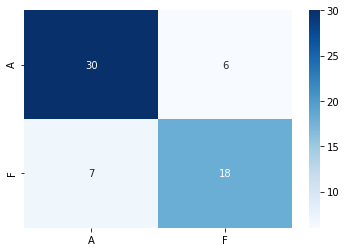

In [21]:
accuracy, cf_matrix, class_report = get_metrics(rf, x_test, y_test)
print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)
sns.heatmap(cf_matrix, annot = True, xticklabels = grades, yticklabels = grades, cmap = 'Blues')

[0.02746655 0.02766605 0.01453975 0.02377356 0.01436935 0.02665493
 0.07305179 0.05334266 0.03434663 0.09110222 0.02899415 0.07243636
 0.04105345 0.06270224 0.00497373 0.00732102 0.0072163  0.01527052
 0.01973949 0.00566186 0.00117333 0.00125166 0.15005024 0.03115778
 0.16468441] [20 21 14 19 16 15  4  2 17 18  3  5  0  1 10 23  8 12  7 13 11  6  9 22
 24]


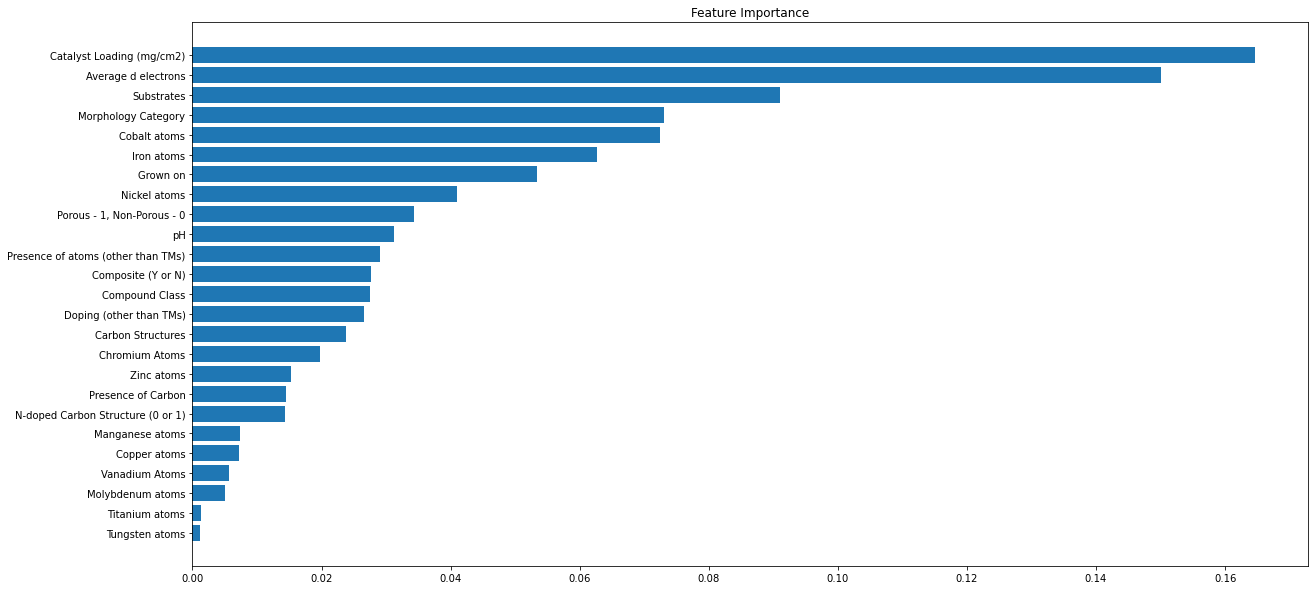

In [22]:
feature_importance, sorted_idx = get_feature_importance_from_trained_model(rf)
plot_feature_importance(feature_importance, sorted_idx)
print(feature_importance, sorted_idx)

In [23]:
a,b = [], []
for i in range(len(sorted_idx)-1, -1, -1):
    a.append(training_features[sorted_idx[i]])
    b.append(feature_importance[sorted_idx[i]])
    
df_feature_importance = pd.DataFrame({'Features':a, 'Values': b})
df_feature_importance.to_csv("feature_importance.csv")

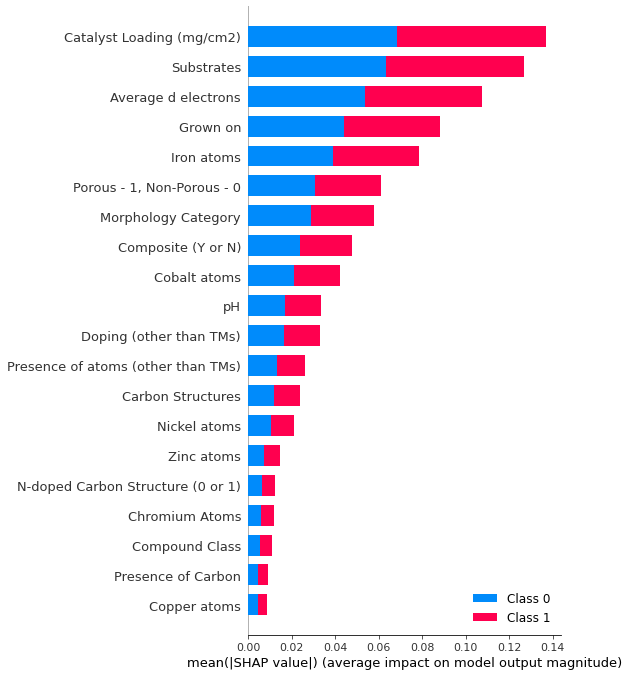

In [24]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names = training_features)

In [25]:
rf_resultX = pd.DataFrame(shap_values[0], columns = training_features)

vals = np.abs(rf_resultX.values).mean(0)

df_shap = pd.DataFrame(list(zip(training_features, vals)),
                                  columns=['col_name','feature_importance_vals'])
df_shap.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
df_shap.to_csv("shap_values.csv")

## SVM

In [26]:
from sklearn import svm

clf = svm.SVC(random_state=0)
clf.fit(x_train, y_train)

SVC(random_state=0)

In [27]:
y_pred = clf.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
accuracy = accuracy_score(y_test, y_pred )
class_report = classification_report(y_test, y_pred)

print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)

accuracy_score:  0.5901639344262295
classification_report: 
               precision    recall  f1-score   support

           A       0.59      0.97      0.74        36
           F       0.50      0.04      0.07        25

    accuracy                           0.59        61
   macro avg       0.55      0.51      0.41        61
weighted avg       0.56      0.59      0.47        61



## Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [29]:
y_pred = gnb.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
accuracy = accuracy_score(y_test, y_pred )
class_report = classification_report(y_test, y_pred)

print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)

accuracy_score:  0.7213114754098361
classification_report: 
               precision    recall  f1-score   support

           A       0.72      0.86      0.78        36
           F       0.72      0.52      0.60        25

    accuracy                           0.72        61
   macro avg       0.72      0.69      0.69        61
weighted avg       0.72      0.72      0.71        61



## MLP

In [30]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
mlp.fit(x_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier(random_state=0)

In [31]:
y_pred = mlp.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred, labels = grades)
accuracy = accuracy_score(y_test, y_pred )
class_report = classification_report(y_test, y_pred)

print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)

accuracy_score:  0.7049180327868853
classification_report: 
               precision    recall  f1-score   support

           A       0.71      0.83      0.77        36
           F       0.68      0.52      0.59        25

    accuracy                           0.70        61
   macro avg       0.70      0.68      0.68        61
weighted avg       0.70      0.70      0.70        61



## CatBoost

In [32]:
from catboost import CatBoostClassifier, Pool

In [33]:
def create_train_pool():
    cat_cols = [0,1,2,3,4,5,6,7,8,9]  

    train_pool = Pool(
            x_train,
            y_train,
            cat_features=cat_cols
    )
    return train_pool

In [34]:
def define_model_parameters():

    model = CatBoostClassifier(
    iterations=500,
    depth=5,
    random_seed= 0,
    )

    eval_set = [(x_train, y_train), (x_test, y_test)]
    return eval_set, model

In [35]:
train_pool = create_train_pool()
eval_set, cat_boost_model = define_model_parameters()

cat_boost_model.fit( 
    train_pool,
    eval_set = eval_set
    )

Learning rate set to 0.030237
0:	learn: 0.6818947	test: 0.6820835	test1: 0.6828794	best: 0.6828794 (0)	total: 184ms	remaining: 1m 31s
1:	learn: 0.6745092	test: 0.6746109	test1: 0.6753278	best: 0.6753278 (1)	total: 220ms	remaining: 54.9s
2:	learn: 0.6678141	test: 0.6677132	test1: 0.6718132	best: 0.6718132 (2)	total: 270ms	remaining: 44.7s
3:	learn: 0.6586368	test: 0.6582642	test1: 0.6660009	best: 0.6660009 (3)	total: 305ms	remaining: 37.8s
4:	learn: 0.6504542	test: 0.6496998	test1: 0.6635828	best: 0.6635828 (4)	total: 341ms	remaining: 33.7s
5:	learn: 0.6431973	test: 0.6418075	test1: 0.6550382	best: 0.6550382 (5)	total: 372ms	remaining: 30.6s
6:	learn: 0.6374739	test: 0.6368630	test1: 0.6502712	best: 0.6502712 (6)	total: 400ms	remaining: 28.1s
7:	learn: 0.6311660	test: 0.6306580	test1: 0.6471665	best: 0.6471665 (7)	total: 424ms	remaining: 26.1s
8:	learn: 0.6255979	test: 0.6248058	test1: 0.6437326	best: 0.6437326 (8)	total: 444ms	remaining: 24.2s
9:	learn: 0.6204357	test: 0.6192100	test1:

82:	learn: 0.4220375	test: 0.4587376	test1: 0.5244239	best: 0.5239317 (81)	total: 3.19s	remaining: 16s
83:	learn: 0.4203164	test: 0.4586534	test1: 0.5256078	best: 0.5239317 (81)	total: 3.22s	remaining: 15.9s
84:	learn: 0.4182493	test: 0.4577880	test1: 0.5255087	best: 0.5239317 (81)	total: 3.25s	remaining: 15.8s
85:	learn: 0.4164333	test: 0.4562532	test1: 0.5243210	best: 0.5239317 (81)	total: 3.28s	remaining: 15.8s
86:	learn: 0.4149802	test: 0.4551411	test1: 0.5241652	best: 0.5239317 (81)	total: 3.33s	remaining: 15.8s
87:	learn: 0.4142295	test: 0.4549400	test1: 0.5237465	best: 0.5237465 (87)	total: 3.37s	remaining: 15.8s
88:	learn: 0.4142079	test: 0.4549568	test1: 0.5237533	best: 0.5237465 (87)	total: 3.38s	remaining: 15.6s
89:	learn: 0.4127062	test: 0.4535324	test1: 0.5249121	best: 0.5237465 (87)	total: 3.42s	remaining: 15.6s
90:	learn: 0.4111967	test: 0.4521748	test1: 0.5247012	best: 0.5237465 (87)	total: 3.47s	remaining: 15.6s
91:	learn: 0.4099324	test: 0.4507766	test1: 0.5236002	bes

161:	learn: 0.3298780	test: 0.3974905	test1: 0.5091260	best: 0.5080861 (159)	total: 6.13s	remaining: 12.8s
162:	learn: 0.3297043	test: 0.3974885	test1: 0.5092776	best: 0.5080861 (159)	total: 6.17s	remaining: 12.8s
163:	learn: 0.3289382	test: 0.3975438	test1: 0.5087629	best: 0.5080861 (159)	total: 6.21s	remaining: 12.7s
164:	learn: 0.3272836	test: 0.3960016	test1: 0.5073717	best: 0.5073717 (164)	total: 6.25s	remaining: 12.7s
165:	learn: 0.3266169	test: 0.3959321	test1: 0.5077177	best: 0.5073717 (164)	total: 6.29s	remaining: 12.7s
166:	learn: 0.3249425	test: 0.3944967	test1: 0.5072617	best: 0.5072617 (166)	total: 6.32s	remaining: 12.6s
167:	learn: 0.3236305	test: 0.3930003	test1: 0.5072292	best: 0.5072292 (167)	total: 6.36s	remaining: 12.6s
168:	learn: 0.3229483	test: 0.3923899	test1: 0.5077136	best: 0.5072292 (167)	total: 6.39s	remaining: 12.5s
169:	learn: 0.3216182	test: 0.3921853	test1: 0.5076100	best: 0.5072292 (167)	total: 6.43s	remaining: 12.5s
170:	learn: 0.3211308	test: 0.3920002

243:	learn: 0.2706901	test: 0.3588785	test1: 0.4973856	best: 0.4970657 (242)	total: 9.29s	remaining: 9.74s
244:	learn: 0.2705677	test: 0.3588390	test1: 0.4973684	best: 0.4970657 (242)	total: 9.32s	remaining: 9.7s
245:	learn: 0.2697488	test: 0.3579572	test1: 0.4969710	best: 0.4969710 (245)	total: 9.37s	remaining: 9.67s
246:	learn: 0.2692904	test: 0.3574938	test1: 0.4964464	best: 0.4964464 (246)	total: 9.41s	remaining: 9.64s
247:	learn: 0.2690412	test: 0.3573089	test1: 0.4971008	best: 0.4964464 (246)	total: 9.46s	remaining: 9.61s
248:	learn: 0.2678537	test: 0.3562635	test1: 0.4972226	best: 0.4964464 (246)	total: 9.49s	remaining: 9.57s
249:	learn: 0.2676485	test: 0.3562553	test1: 0.4971229	best: 0.4964464 (246)	total: 9.53s	remaining: 9.53s
250:	learn: 0.2667229	test: 0.3554657	test1: 0.4961642	best: 0.4961642 (250)	total: 9.57s	remaining: 9.49s
251:	learn: 0.2658686	test: 0.3549019	test1: 0.4955213	best: 0.4955213 (251)	total: 9.61s	remaining: 9.45s
252:	learn: 0.2652012	test: 0.3544805	

320:	learn: 0.2218804	test: 0.3206148	test1: 0.4920900	best: 0.4892848 (274)	total: 12.3s	remaining: 6.87s
321:	learn: 0.2208845	test: 0.3202244	test1: 0.4927366	best: 0.4892848 (274)	total: 12.4s	remaining: 6.83s
322:	learn: 0.2195341	test: 0.3185063	test1: 0.4921652	best: 0.4892848 (274)	total: 12.4s	remaining: 6.8s
323:	learn: 0.2178558	test: 0.3179016	test1: 0.4924967	best: 0.4892848 (274)	total: 12.4s	remaining: 6.76s
324:	learn: 0.2171482	test: 0.3174648	test1: 0.4927082	best: 0.4892848 (274)	total: 12.5s	remaining: 6.73s
325:	learn: 0.2168105	test: 0.3173670	test1: 0.4925987	best: 0.4892848 (274)	total: 12.5s	remaining: 6.69s
326:	learn: 0.2163187	test: 0.3172643	test1: 0.4926525	best: 0.4892848 (274)	total: 12.6s	remaining: 6.65s
327:	learn: 0.2162196	test: 0.3172329	test1: 0.4928217	best: 0.4892848 (274)	total: 12.6s	remaining: 6.62s
328:	learn: 0.2149524	test: 0.3164430	test1: 0.4935164	best: 0.4892848 (274)	total: 12.7s	remaining: 6.58s
329:	learn: 0.2146387	test: 0.3163962	

397:	learn: 0.1859433	test: 0.2941436	test1: 0.5094228	best: 0.4892848 (274)	total: 15.6s	remaining: 3.99s
398:	learn: 0.1855705	test: 0.2939797	test1: 0.5093674	best: 0.4892848 (274)	total: 15.6s	remaining: 3.96s
399:	learn: 0.1852091	test: 0.2936505	test1: 0.5090868	best: 0.4892848 (274)	total: 15.7s	remaining: 3.92s
400:	learn: 0.1851442	test: 0.2934703	test1: 0.5089166	best: 0.4892848 (274)	total: 15.7s	remaining: 3.88s
401:	learn: 0.1839633	test: 0.2919396	test1: 0.5100426	best: 0.4892848 (274)	total: 15.7s	remaining: 3.84s
402:	learn: 0.1827275	test: 0.2908143	test1: 0.5092643	best: 0.4892848 (274)	total: 15.8s	remaining: 3.8s
403:	learn: 0.1823886	test: 0.2903813	test1: 0.5089315	best: 0.4892848 (274)	total: 15.8s	remaining: 3.76s
404:	learn: 0.1820333	test: 0.2901571	test1: 0.5082837	best: 0.4892848 (274)	total: 15.9s	remaining: 3.72s
405:	learn: 0.1816782	test: 0.2902367	test1: 0.5083539	best: 0.4892848 (274)	total: 15.9s	remaining: 3.68s
406:	learn: 0.1808877	test: 0.2893732	

478:	learn: 0.1562251	test: 0.2698958	test1: 0.5132206	best: 0.4892848 (274)	total: 19.1s	remaining: 837ms
479:	learn: 0.1560638	test: 0.2696250	test1: 0.5133843	best: 0.4892848 (274)	total: 19.1s	remaining: 797ms
480:	learn: 0.1560014	test: 0.2696391	test1: 0.5132877	best: 0.4892848 (274)	total: 19.2s	remaining: 757ms
481:	learn: 0.1557931	test: 0.2696500	test1: 0.5139180	best: 0.4892848 (274)	total: 19.2s	remaining: 717ms
482:	learn: 0.1553306	test: 0.2698648	test1: 0.5145111	best: 0.4892848 (274)	total: 19.2s	remaining: 677ms
483:	learn: 0.1550302	test: 0.2699154	test1: 0.5148882	best: 0.4892848 (274)	total: 19.3s	remaining: 637ms
484:	learn: 0.1541863	test: 0.2693593	test1: 0.5165651	best: 0.4892848 (274)	total: 19.3s	remaining: 597ms
485:	learn: 0.1539204	test: 0.2693097	test1: 0.5165435	best: 0.4892848 (274)	total: 19.3s	remaining: 557ms
486:	learn: 0.1535368	test: 0.2694316	test1: 0.5161344	best: 0.4892848 (274)	total: 19.4s	remaining: 517ms
487:	learn: 0.1527414	test: 0.2688406

accuracy_score:  0.7540983606557377
classification_report: 
               precision    recall  f1-score   support

           A       0.77      0.83      0.80        36
           F       0.73      0.64      0.68        25

    accuracy                           0.75        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.75      0.75        61



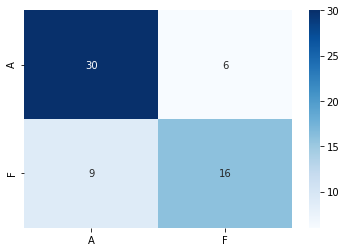

In [36]:
accuracy, cf_matrix, class_report = get_metrics(cat_boost_model, x_test, y_test)
print("accuracy_score: ", accuracy)
print("classification_report: \n", class_report)
sns.heatmap(cf_matrix, annot = True, xticklabels = grades, yticklabels = grades, cmap = 'Blues')